# Audience Ratings Prediction

The dataset has been extracted from an audience appreciation survey which is filled in each day by a panel of respondents. The dataset contains comments from viewers about a show, specifically the answer to the question: “what did you like or did not like about the show”. Respondents are also asked to rate each episode on a scale of 1 to 10. This rating is called the appreciation index (AI score) so each comment is associated with a rating. The datasets also include some basic demographics information and the date of the episode.

Contains all comments from 2017 (28,563) from January to December.

Our aim:
- Gain insight into these 28,563 responses without having to read and analyse every single response
- Build word frequency and word cloud graphs
- Build a model to predict the AI score and raise red flags for potential drops in AI 

### Table of Contents
#### 1. [Data Exploration](#Data-Exploration)
#### 2. [Text Preparation](#Text-Preparation-EA)    
#### 3. [Word Frequency](#Word-Frequency-EA)
#### 3. [Defining Sentiment Scores](#Defining-Sentiment-Scores-EA)
#### 4. [Model Building - Naive Bayes](#Models---Naive-Bayes-EA)


## Data Exploration <a class="anchor" id="Data-Exploration"></a>

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file = 'eastenders_pulse_dataset.csv' # The data is provided in csv format

df = pd.read_csv(file, sep=',' , encoding='latin-1', error_bad_lines=False)

In [72]:
df.head(10)

,date,comment,respid,progtitle,gender,age,ai_score
0,01/01/2017,Great soap,13193094,EastEnders,2,54,10
1,01/01/2017,"OMG, RONNIE OMG , ROXY WHAT A BLOODY ENDING , ...",14197241,EastEnders,2,48,10
2,01/01/2017,"A regular choice,,was a sad ending this one",16483052,EastEnders,1,46,10
3,01/01/2017,rather unsavoury ending,2688501,EastEnders,2,75,5
4,01/01/2017,Wow... What a shock ending.,13693763,EastEnders,2,45,10
5,01/01/2017,GOT RID OF THE WRONG PEOPLE.,10795356,EastEnders,2,65,7
6,01/01/2017,I have started watching EastEnders again after...,15467296,EastEnders,2,68,10
7,01/01/2017,Shocking. Why did they have to die? The girls ...,1720221,EastEnders,2,73,8
8,01/01/2017,good storylines,14390909,EastEnders,1,34,9
9,01/01/2017,Filming was good but didnt like the way the Mi...,13763311,EastEnders,2,61,3


In [73]:
# Data cleaning

# We are not going to use the following three columns: 
# date: we are not doing temporal analysis. 
# respid: this does not help answering our questions
# pogtitle: this is the same for all comments

df = df.drop(['date', 'respid', 'progtitle'], axis = 1)


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28563 entries, 0 to 28562
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comment   28560 non-null  object
 1   gender    28563 non-null  int64 
 2   age       28563 non-null  int64 
 3   ai_score  28563 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 892.7+ KB


In [75]:
# we need to convert this feature from object to unicode string, otherwise we won't be able to manipulate it later on
df['comment'] = df['comment'].astype('U')

In [76]:
df.describe()

,gender,age,ai_score
count,28563.000000,28563.000000,28563.000000
mean,1.691279,56.655708,7.269545
std,0.461974,13.697989,2.484923
min,1.000000,16.000000,1.000000
25%,1.000000,48.000000,6.000000
50%,2.000000,58.000000,8.000000
75%,2.000000,67.000000,9.000000
max,2.000000,94.000000,10.000000


<AxesSubplot:xlabel='gender', ylabel='count'>

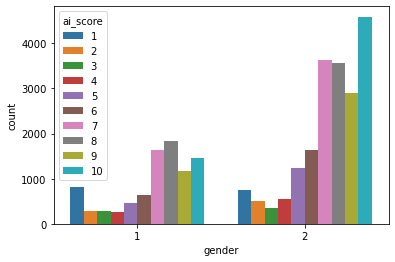

In [77]:
import seaborn as sns

# just to look at the distribution of the scoring by gender
sns.countplot( x = df['gender'],hue = df['ai_score'])

<AxesSubplot:xlabel='ai_score', ylabel='Count'>

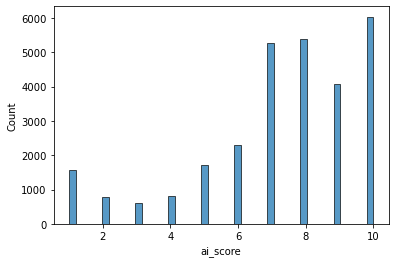

In [78]:
# Looking at distribution of how the audience scored the programmes. 

sns.histplot(df['ai_score'])

# As we can see this is skewed to the left. We will keep an eye on this when building a predictive model as it may casue bias. 


<AxesSubplot:xlabel='age', ylabel='Count'>

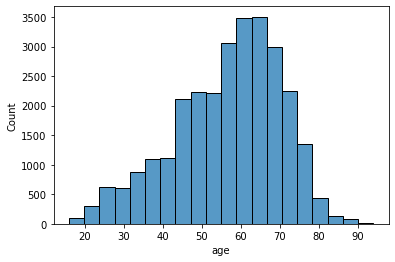

In [79]:
# looking at the age distribution, which looks like a normal distribution with a mean of around 60.
sns.histplot(df.age, bins = 20)

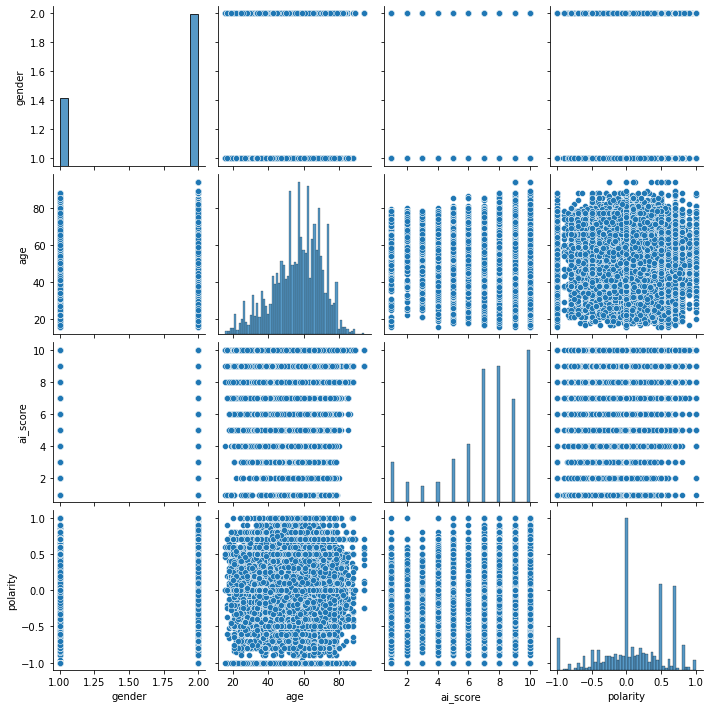

In [138]:
#df = dat[['gender','Loan_amount','Investment','age','work_exp']]
sns.pairplot(df, kind="scatter")
plt.show()

array([[ 1.        , -0.13153828],
       [-0.13153828,  1.        ]])

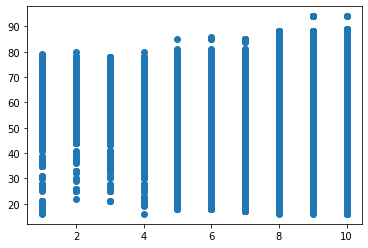

In [145]:
# It would be useful to look for outliers so we plot the score that the audience member has given against their age, to see if there are any particular outliers according to age. 
plt.scatter(df['ai_score'], df['age'])
np.corrcoef(df['age'], df['ai_score'])

In [146]:
from scipy.stats import linregress

linregress(df['age'], df['ai_score'])

LinregressResult(slope=-0.023862073713633823, intercept=8.62146720658208, rvalue=-0.13153827788702077, pvalue=2.027534795201856e-110, stderr=0.0010640922798348862)

In [80]:
# Next, we look at what the comments look like and if they need manipulaiton before being used in our model.
df.comment

0                                               Great soap
1        OMG, RONNIE OMG , ROXY WHAT A BLOODY ENDING , ...
2              A regular choice,,was a sad ending this one
3                                  rather unsavoury ending
4                              Wow... What a shock ending.
                               ...                        
28558    Why are soaps always doom and gloom at Christmas?
28559           OK but a bit stupid in places far fetched.
28560                                       Regular choice
28561                                                SO SO
28562      This is more like it. Back to form at long last
Name: comment, Length: 28563, dtype: object

# Text Preparation <a class="anchor" id="Text-Preparation-EA"></a>

In [81]:
# Remove punctuation from comments and make them all lower case
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'[a-zA-Z_0-9]\w+', '') # this RegEx argument removes all punctuations and only keeps text, as opposed to numbers

df['comment'] = df['comment'].apply(lambda x: tokenizer.tokenize(x.lower())) # the lower() method turns all characters to lower case 
df['comment'].head(10)

0                                        [great, soap]
1    [omg, ronnie, omg, roxy, what, bloody, ending,...
2       [regular, choice, was, sad, ending, this, one]
3                          [rather, unsavoury, ending]
4                           [wow, what, shock, ending]
5                   [got, rid, of, the, wrong, people]
6    [have, started, watching, eastenders, again, a...
7    [shocking, why, did, they, have, to, die, the,...
8                                   [good, storylines]
9    [filming, was, good, but, didnt, like, the, wa...
Name: comment, dtype: object

In [82]:
# Remove stopwords from comments

from nltk.corpus import stopwords

stop = stopwords.words('english')

df['comment'] = df['comment'].apply(lambda x: [w for w in x if w not in stop])
df['comment'].head(10)

0                                        [great, soap]
1    [omg, ronnie, omg, roxy, bloody, ending, wow, ...
2                  [regular, choice, sad, ending, one]
3                          [rather, unsavoury, ending]
4                                 [wow, shock, ending]
5                            [got, rid, wrong, people]
6    [started, watching, eastenders, considerable, ...
7    [shocking, die, girls, interesting, characters...
8                                   [good, storylines]
9    [filming, good, didnt, like, way, mitchell, si...
Name: comment, dtype: object

In [83]:
# Lemmatizing to take words back to their root form
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

df['comment'] = df['comment'].apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
df['comment'].head(10)


0                                        [great, soap]
1    [omg, ronnie, omg, roxy, bloody, ending, wow, ...
2                  [regular, choice, sad, ending, one]
3                          [rather, unsavoury, ending]
4                                 [wow, shock, ending]
5                            [got, rid, wrong, people]
6    [started, watching, eastenders, considerable, ...
7    [shocking, die, girl, interesting, character, ...
8                                    [good, storyline]
9    [filming, good, didnt, like, way, mitchell, si...
Name: comment, dtype: object

# Word Frequency <a class="anchor" id="Word-Frequency-EA"></a>

In [84]:
# Joining all the comments together to calcaulte word frequency
text = "".join(comment for comment in df.comment.astype(str))
print ("There are {} words in the combination of all review.".format(len(text)))


There are 1753257 words in the combination of all review.


<function matplotlib.pyplot.show(close=None, block=None)>

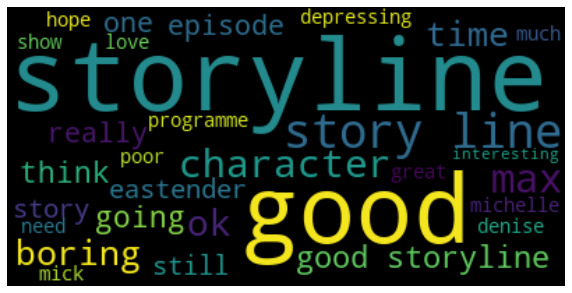

In [85]:
from wordcloud import WordCloud 

# Plotting a word cloud 
wordcloud = WordCloud(max_words = 30, regexp = r"\w+").generate(text)

plt.figure(figsize = (10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

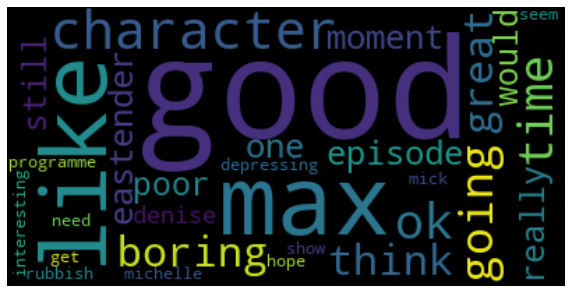

In [86]:
# Some words are very common but they don't add anything to our analysis, so we remove these

STOPWORDS = ['storyline', 'story line', 'story  line', 'line', 'story']

stopwords = set(STOPWORDS)

wordcloud = WordCloud(stopwords = stopwords, max_words = 30, regexp = r"\w+").generate(text)

plt.figure(figsize = (10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show

Negative reviews


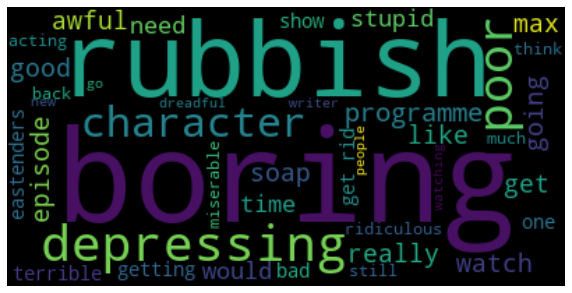

Positive reviews


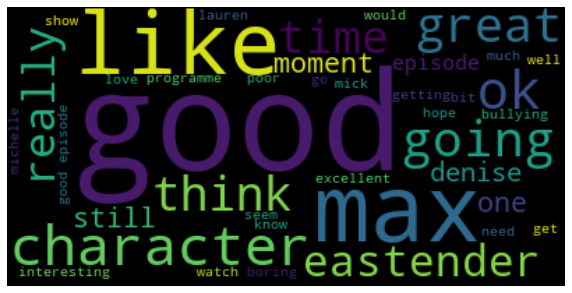

In [87]:
# Now we have a look at words that are most common in the most negative reviews 
# and those that are most common in positive reviews.

STOPWORDS = ['storyline', 'story line', 'story  line', 'line', 'story']

stopwords = set(STOPWORDS)

# Most negative
df_selection=df[df['ai_score']<5]
text = " ".join(comment for comment in df_selection.comment.astype(str))

wordcloud1 = WordCloud(stopwords = stopwords, max_words = 40, regexp = r"\w+").generate(text)

# Most Positive
df_selection=df[df['ai_score']>5]
text = " ".join(comment for comment in df_selection.comment.astype(str))

wordcloud2 = WordCloud(stopwords = stopwords, max_words = 40, regexp = r"\w+").generate(text)


plt.figure(figsize = (10,10))
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
print("Negative reviews")
plt.show()

plt.figure(figsize = (10,10))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
print("Positive reviews")
plt.show()


In [88]:
from nltk.probability import FreqDist
# We are looking to gain more insight into those word cloud plots. So we dive depen in frequency distribution.

# this RegEx argument removes all punctuations and only keeps text, as opposed to number
#tokenizer = RegexpTokenizer(r'[a-zA-Z_0-9]\w+', '') 

tokenized_text = tokenizer.tokenize(text) # we use the same tokenizer as the one we did before. 

# Find frequency distribution of the words

fdist = FreqDist(tokenized_text)

In [89]:
# Two most common words
fdist.most_common(2)

[('good', 5105), ('storyline', 4020)]

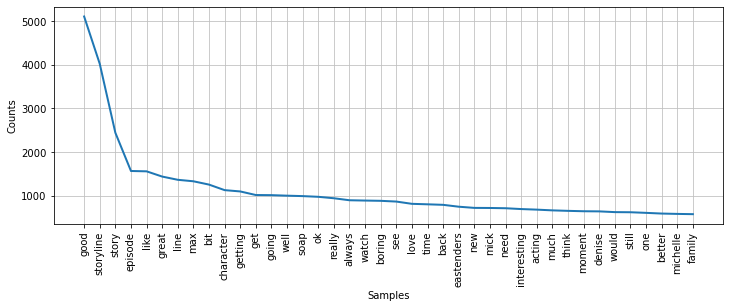

In [90]:
# Plot the words distribution
plt.figure(figsize = (12, 4))
fdist.plot(40,cumulative=False)
plt.show()

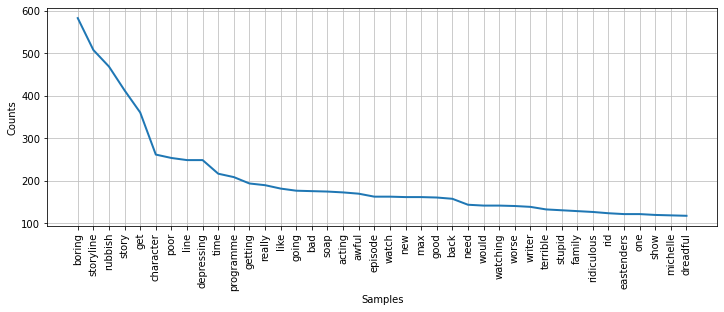

In [91]:
# Again, it is helpful to dive deeper for the most negative and positive words.

# Most negative
df_selection=df[df['ai_score']<5]
text = " ".join(comment for comment in df_selection.comment.astype(str))
tokenized_text = tokenizer.tokenize(text) # we use the same tokenizer as the one we did before. 
fdist1 = FreqDist(tokenized_text)
plt.figure(figsize = (12, 4))
fdist1.plot(40,cumulative=False)
plt.show()



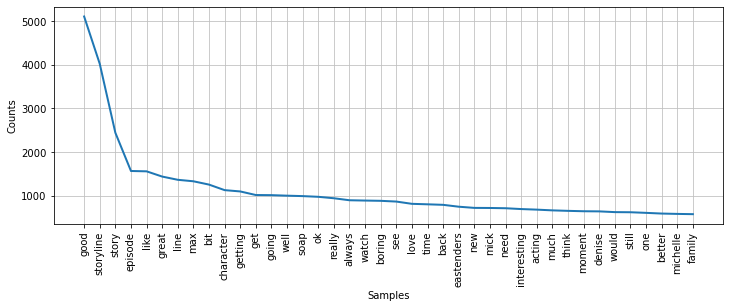

In [92]:
# Most positive
df_selection=df[df['ai_score']>5]
text = " ".join(comment for comment in df_selection.comment.astype(str))
tokenized_text = tokenizer.tokenize(text) # we use the same tokenizer as the one we did before. 
fdist1 = FreqDist(tokenized_text)
plt.figure(figsize = (12, 4))
fdist1.plot(40,cumulative=False)
plt.show()


In [147]:
def get_num_words_per_sample(sample_texts):
    """Gets the median number of words per sample given corpus.
    # Arguments
        sample_texts: list, sample texts.
    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

In [148]:
get_num_words_per_sample(text)

1.0

In [152]:
# we need to calculate the numver of samples / number of words per sample ratio
# https://developers.google.com/machine-learning/guides/text-classification/step-2-5


print(len(text))

# so our sample to number_of_words_per_sample ratio is well above 1500. 



######### ______________
# REDUCE the dimension, in other words take a sub sample fo the data to make sure this ratio falls below 1500. Then implement MLP like google link above.


1406193


## Defining Sentiment Scores <a class="anchor" id="Defining-Sentiment-Scores-EA"></a>

We need to take into account he ordinal nature of these scores. The steps between scores are the same, in single increments, but a 2 step change has to be different to a 7. As such we perform a sentiment analysis to see the strength of what people are commenting about. This will help us decide how many classes we need.

In [93]:
from textblob import TextBlob # we use the built-in sentiment scores of TextBlob

# Let's have a look at the level of positivity and negativity in the comments (according to TextBlob) 
df['polarity'] = df['comment'].astype(str).map(lambda text: TextBlob(text).sentiment.polarity)
df.head(10)

,comment,gender,age,ai_score,polarity
0,"[great, soap]",2,54,10,0.800000
1,"[omg, ronnie, omg, roxy, bloody, ending, wow, ...",2,48,10,-0.366667
2,"[regular, choice, sad, ending, one]",1,46,10,-0.250000
3,"[rather, unsavoury, ending]",2,75,5,0.000000
4,"[wow, shock, ending]",2,45,10,0.100000
5,"[got, rid, wrong, people]",2,65,7,-0.500000
6,"[started, watching, eastenders, considerable, ...",2,68,10,0.000000
7,"[shocking, die, girl, interesting, character, ...",2,73,8,-0.166667
8,"[good, storyline]",1,34,9,0.700000
9,"[filming, good, didnt, like, way, mitchell, si...",2,61,3,0.700000


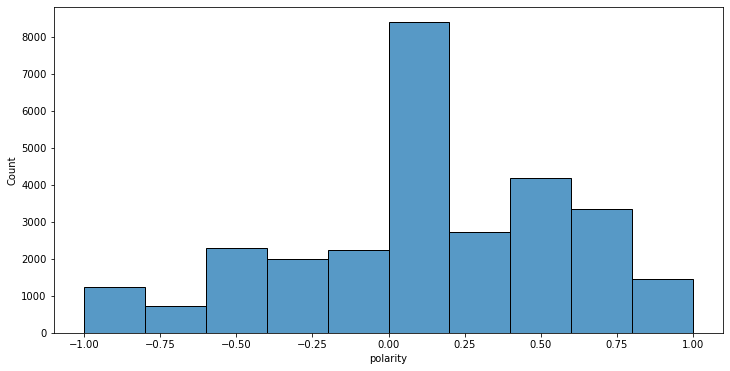

In [94]:
# I plot the distribution of the polarity
plt.figure(figsize=(12,6))
_ = sns.histplot(df['polarity'], bins=10)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='age', ylabel='polarity'>

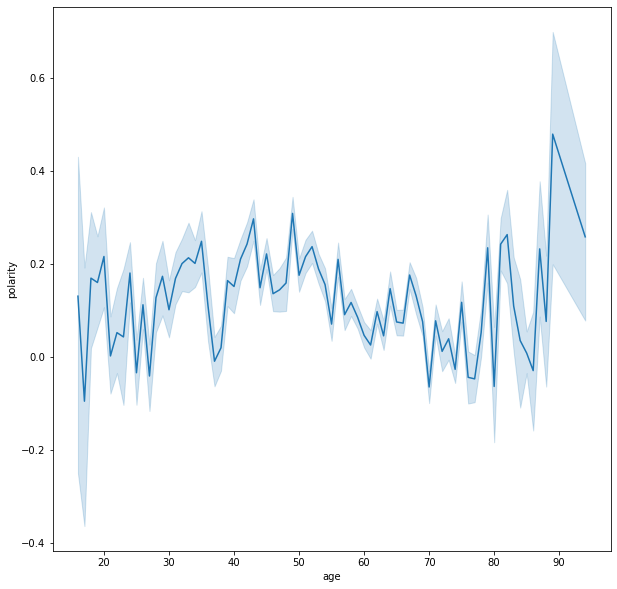

In [95]:
plt.figure(figsize=(10,10))
sns.lineplot(df['age'], df['polarity'])

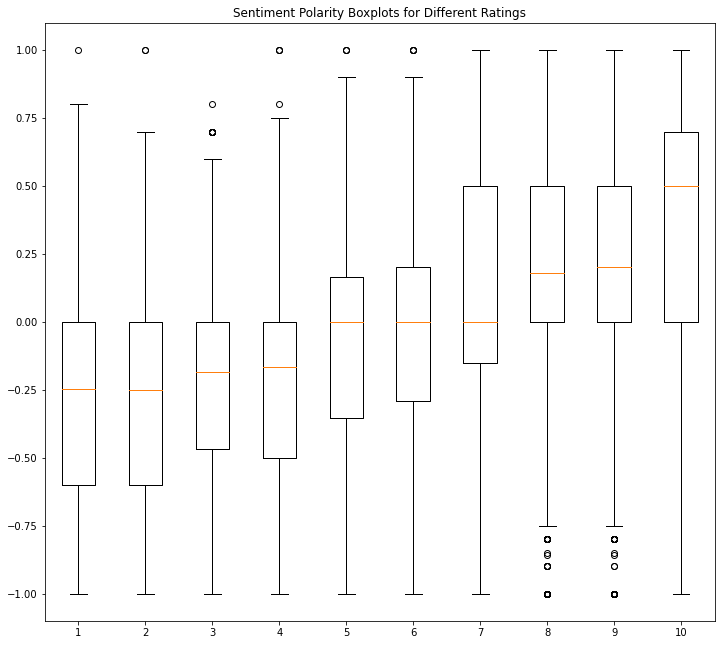

In [96]:
# And the box plots
y0 = df.loc[df['ai_score'] == 1]['polarity']
y1 = df.loc[df['ai_score'] == 2]['polarity']
y2 = df.loc[df['ai_score'] == 3]['polarity']
y3 = df.loc[df['ai_score'] == 4]['polarity']
y4 = df.loc[df['ai_score'] == 5]['polarity']
y5 = df.loc[df['ai_score'] == 6]['polarity']
y6 = df.loc[df['ai_score'] == 7]['polarity']
y7 = df.loc[df['ai_score'] == 8]['polarity']
y8 = df.loc[df['ai_score'] == 9]['polarity']
y9 = df.loc[df['ai_score'] == 10]['polarity']

data = [y0,y1,y2,y3,y4,y5,y6,y7,y8,y9]

# Multiple box plots on one Axes
fig, ax = plt.subplots(figsize=(12, 11))
_ = ax.set_title("Sentiment Polarity Boxplots for Different Ratings")
_ = ax.boxplot(data)

plt.show()

Looking at the polairty box plot we can deduce three different classes:
- 1 to 4 will be put in negative
- 4 to 7 will be put in neutral
- 8 to 10 will be put in positive

This is based on the sentiment analysis which uses TexBlob's built in polarity scores. 

In [100]:
# creating classes

sentiment = []

for s in df['ai_score']:
    if s <= 4:
        sentiment.append('negative')
    elif s >= 5 and s <=7:
        sentiment.append('neutral')
    elif s >= 8 and s <= 10:
        sentiment.append('positive')

df['sentiment'] = sentiment


# Model Duilding - Naive Bayes <a class="anchor" id="Models---Naive-Bayes-EA"></a>

In [103]:
# We use TF-IDF to vectorize the text before building the model
from sklearn.feature_extraction.text import TfidfVectorizer
tf=TfidfVectorizer()
text_tf= tf.fit_transform(df['comment'].astype(str))

In [101]:
# Target variable
y = df['sentiment']

In [104]:
# Split out data into train and test sets
from sklearn.model_selection import train_test_split

X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
    text_tf, y, test_size=0.3, random_state=1)

In [105]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Training fitting and printing the score of a multinomial naive bayes model

nb_model_tv = MultinomialNB().fit(X_train_tfidf, y_train)
pred_tv = nb_model_tv.predict(X_test_tfidf)
score = accuracy_score(y_test, pred_tv)
print(score) 

0.6326292449527366


              precision    recall  f1-score   support

    negative       0.86      0.16      0.27      1176
     neutral       0.54      0.35      0.43      2768
    positive       0.65      0.92      0.76      4625

    accuracy                           0.63      8569
   macro avg       0.68      0.48      0.49      8569
weighted avg       0.64      0.63      0.59      8569



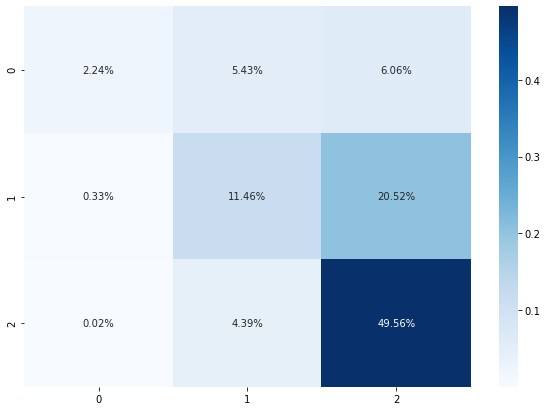

In [107]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm_tv = confusion_matrix(y_test, pred_tv)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_tv/np.sum(cm_tv), annot=True, 
            fmt='.2%', cmap='Blues')
print(classification_report(y_test, pred_tv))